In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading and investigating the data

In [4]:
data = pd.read_csv('bankdata.csv')

In [5]:
data.shape

(74364, 9)

In [6]:
data.dtypes

type             object
operation        object
amount_total    float64
balance         float64
k_symbol         object
amount_left       int64
duration          int64
payments        float64
status           object
dtype: object

In [7]:
data.head()

,type,operation,amount_total,balance,k_symbol,amount_left,duration,payments,status
0,PRIJEM,prevod,44749.0,45549.0,unknown,79608,24,3317.0,A
1,PRIJEM,vklad,1000.0,1000.0,unknown,52788,12,4399.0,A
2,PRIJEM,vklad,1100.0,1100.0,unknown,21924,36,609.0,A
3,PRIJEM,vklad,700.0,700.0,unknown,23052,12,1921.0,A
4,PRIJEM,vklad,900.0,900.0,unknown,41904,12,3492.0,A


In [8]:
data["status"].value_counts()

A    64599
B     9765
Name: status, dtype: int64

In [9]:
# What would be interesting questions to model out of the data with supervised algorithm?
#-How likely are you to default?So to predict the status for a customer.
# So we would like to predict if a new customer has status A or B based on the variables we have!

#Every row is one account

### Investigating the numerical variables

In [10]:
data.describe()

# Note: when mean and median are far away: skewed data

# variance/std differ a lot between values. When alg is sensitive for that, you have to be careful. 
# Decision trees are robust to that

,amount_total,balance,amount_left,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


#### Investigating variable duration

In [11]:
data['duration'].value_counts()

# month im comparison to moneatry values.
# But it is also not a continous quantity, so we will convert it in categorical variable

12    28761
24    25155
36    14110
48     4721
60     1617
Name: duration, dtype: int64

In [12]:
# we will convert this to a categorical
data['duration'] = data['duration'].apply(str)

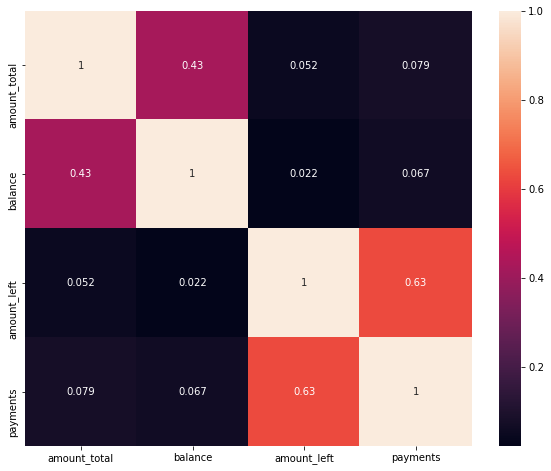

In [13]:
# Checking for multicollinearity
plt.figure(figsize=(10, 8))
ax = sns.heatmap(data.corr(), annot=True)
plt.show()

#### payments and amount_left have a rather high correlation, so we will include only one of them in the model

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


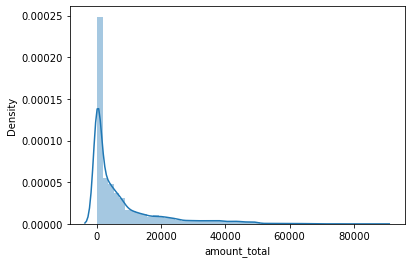

In [14]:
sns.distplot(data['amount_total'])
plt.show()

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


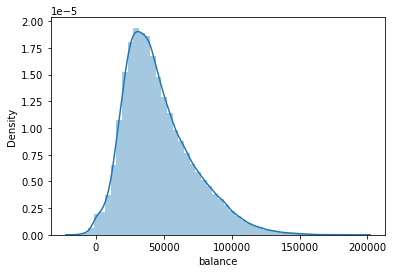

In [15]:
sns.distplot(data['balance'])
plt.show()

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


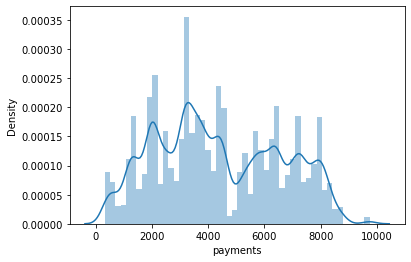

In [16]:
sns.distplot(data['payments'])
plt.show()

### Preprocessing the numerical variables

In [17]:
# we are interested in prediction, not in interpreating the coefficients; therefore we can easily standardize the variables

from sklearn.preprocessing import StandardScaler
data_num = data.select_dtypes(include = np.number).drop(columns = 'amount_left')
# selecting just numerical variables and dropping amount_left from it as we decided not to use it any further
print(data_num.head())
# Standardizing data
transformer = StandardScaler().fit(data_num)
data_num_standardized = transformer.transform(data_num)
x = pd.DataFrame(data_num_standardized, columns = data_num.columns)
print(x.head())

   amount_total  balance  payments
0       44749.0  45549.0    3317.0
1        1000.0   1000.0    4399.0
2        1100.0   1100.0     609.0
3         700.0    700.0    1921.0
4         900.0    900.0    3492.0
   amount_total   balance  payments
0      3.147453 -0.018599 -0.471289
1     -0.582545 -1.769754  0.019231
2     -0.574019 -1.765823 -1.698947
3     -0.608123 -1.781547 -1.104158
4     -0.591071 -1.773685 -0.391953


C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


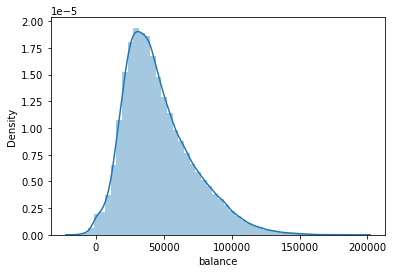

In [18]:
sns.distplot(data['balance'])
plt.show()

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


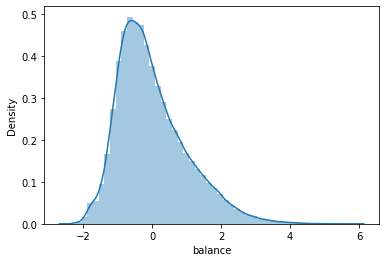

In [19]:
sns.distplot(x['balance'])
plt.show()

In [20]:
# distributional shape basically stays the same. Just mean and variance is standardized. 
# Not absolutely necessary for desicion trees, but for others and it does not hurt desicion trees

### Getting dummies for the categorical variables

In [21]:
from sklearn.preprocessing import OneHotEncoder
cat = data.select_dtypes(include = np.object).drop(columns = 'status')
# dropping status as this is dependent variable
enc = OneHotEncoder()
categorical = pd.DataFrame(enc.fit_transform(cat).toarray(), columns = enc.get_feature_names())
categorical.head()

,x0_PRIJEM,x0_VYBER,x0_VYDAJ,x1_prevod,x1_unknown,x1_vklad,x1_vyber,x2_pojistne,x2_sankc. urok,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_12,x3_24,x3_36,x3_48,x3_60
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
categorical.sum(axis = 1)
# checking for correctness, 4 as we have 4 categorical values

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
74359    4.0
74360    4.0
74361    4.0
74362    4.0
74363    4.0
Length: 74364, dtype: float64

In [23]:
y = data['status']
X = pd.concat((x, categorical), axis=1)
X.head()

,amount_total,balance,payments,x0_PRIJEM,x0_VYBER,x0_VYDAJ,x1_prevod,x1_unknown,x1_vklad,x1_vyber,...,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_12,x3_24,x3_36,x3_48,x3_60
0,3.147453,-0.018599,-0.471289,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.582545,-1.769754,0.019231,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.574019,-1.765823,-1.698947,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.608123,-1.781547,-1.104158,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.591071,-1.773685,-0.391953,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Splitting into train and test set

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

#random_state: to make sure same rows are selected when I run it a second time as far as I add any random number to it
# the number is so to say a name

# random selecting for time series:
#data.loc[] to choose the first each rows

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
logisticr = LogisticRegression(max_iter = 500).fit(X_train, y_train)

In [26]:
predictions = logisticr.predict(X_test)
logisticr.score(X_test, y_test)

#score tells us accuracy.It means we predict 88% of our observations in test set correctly.

0.8806226047199623

In [27]:
print(y_test.value_counts())

A    25839
B     3907
Name: status, dtype: int64


In [28]:
pd.Series(predictions).value_counts()

A    29118
B      628
dtype: int64

In [29]:
#What happened in terms of the classes?
#We are bad at predicting B; bad at minority class - so we did systematic mistakes.

### Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)

In [31]:
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)

# good at decision trees is that we can deal with non-lineary, which log regression could not handle

0.9947555973912459

In [32]:
pd.Series(predictions).value_counts()

A    25817
B     3929
dtype: int64

In [33]:
decisiontree.feature_importances_

#the higher the value, the more important the feature; ordered in same way like our features
# most important features for target variable

array([1.49598911e-02, 1.23554417e-01, 6.53130740e-01, 1.53217084e-03,
       5.84855729e-04, 2.32896616e-04, 2.62897861e-03, 7.52178065e-04,
       1.39701033e-03, 0.00000000e+00, 4.77936035e-04, 0.00000000e+00,
       5.19590488e-04, 0.00000000e+00, 2.35807823e-04, 6.57909199e-04,
       1.99313755e-04, 8.19129677e-02, 6.98743196e-02, 1.98693909e-02,
       9.69774718e-03, 1.77818787e-02])

In [34]:
print(dict(zip(X.columns, decisiontree.feature_importances_)))



{'amount_total': 0.014959891123060474, 'balance': 0.12355441738666695, 'payments': 0.653130739965729, 'x0_PRIJEM': 0.0015321708371917096, 'x0_VYBER': 0.0005848557293973857, 'x0_VYDAJ': 0.0002328966156404733, 'x1_prevod': 0.0026289786124145003, 'x1_unknown': 0.000752178064867558, 'x1_vklad': 0.0013970103294206815, 'x1_vyber': 0.0, 'x2_pojistne': 0.00047793603488584463, 'x2_sankc. urok': 0.0, 'x2_sipo': 0.000519590488138483, 'x2_sluzby': 0.0, 'x2_unknown': 0.00023580782333597943, 'x2_urok': 0.000657909198573384, 'x2_uver': 0.00019931375543874447, 'x3_12': 0.08191296767755006, 'x3_24': 0.0698743195558901, 'x3_36': 0.01986939093043024, 'x3_48': 0.009697747177566458, 'x3_60': 0.01778187869380181}


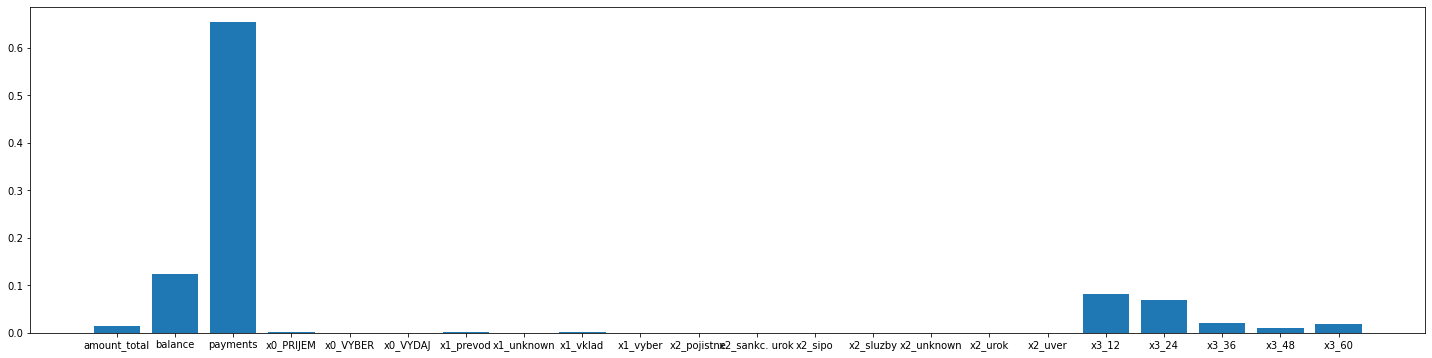

In [35]:
plt.rcParams['figure.figsize'] = [25, 6]
plt.bar(height = decisiontree.feature_importances_, x = X.columns)
plt.show()

### SVM

In [36]:
from sklearn.svm import SVC

svm = SVC().fit(X_train, y_train)
predictions = svm.predict(X_test)
print(svm.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

# SVM is not very scalable, when dataset becomes larger as it takes a lot of time to run
# A = Majority class
# B = Minority class

0.8984737443689907
A    28611
B     1135
dtype: int64


In [37]:
help(SVC)
# SVC uses linear kernel; like linear line -> ususally behaves a little bit worse than datadriven shaped kernel

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  

### K-Nearest Neighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbors = KNeighborsClassifier().fit(X_train, y_train)
predictions = nearest_neighbors.predict(X_test)
print(nearest_neighbors.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

# More scalable than SCV
# Performs awesome on minority class

0.9266455994083238
A    26677
B     3069
dtype: int64


In [39]:
help(KNeighborsClassifier)
# K-Paramters:how many neighbours to take into account.5 equals default

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.NeighborsBase, sklearn.neighbors._base.KNeighborsMixin, sklearn.neighbors._base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of t

### Supervised Learning: Regression

In [40]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# SVR
from sklearn.svm import SVR
# KNN
from sklearn.neighbors import KNeighborsRegressor

## Model Evaluation

### Creating the Confusion Matrix

In [41]:
from sklearn.linear_model import LogisticRegression
logisticr = LogisticRegression().fit(X_train, y_train)

C:\Users\broth\anaconda3\envs\kittycat\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
predictions = logisticr.predict(X_test)
logisticr.score(X_test, y_test)

0.8806226047199623

In [45]:
pd.Series(predictions).value_counts()

A    29118
B      628
dtype: int64

In [43]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

# left side is A
# right side is B
# On main diagonal, we have correctly classified data. Always!
# we try to get main diagonal values as high as possible. Always!
# x-axis is what they truely are, y-axis is what we predict

[[25703   136]
 [ 3415   492]]


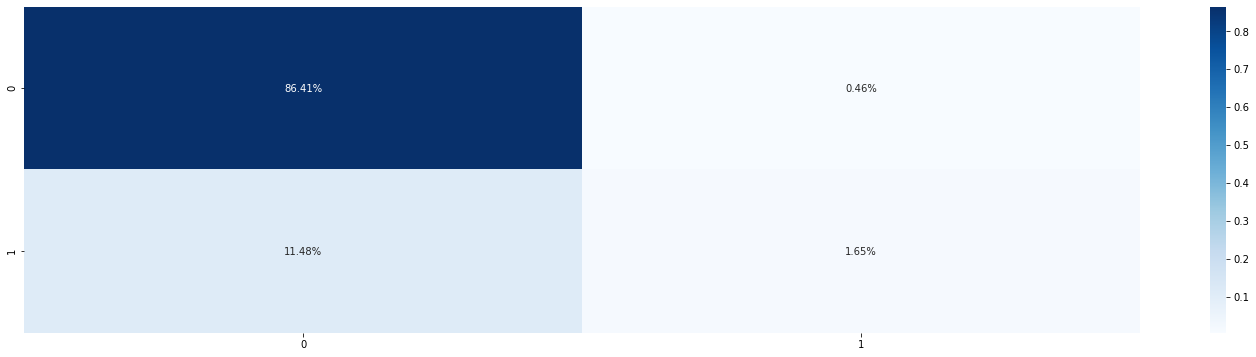

In [46]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()
# 1/1 is true positive in this case
# 0/0 are true negative in this case
# 0/1 (11,48%),we think they are fine, but they are not in reality
# ! Be careful, Order depends on alphabet of my labels! So you can not always say where true/positive etc. will be located!

#### Precision, Recall and the F1 Score

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score
# We need to assign which is the 'positive class'. Here, we are trying to predict whether a customer will run into
# problems repaying their loan. So Status B is the 'positive' class (meaning credit problems = True)
print(precision_score(y_test, predictions, pos_label='B'))
print(recall_score(y_test, predictions, pos_label='B'))
print(f1_score(y_test, predictions, pos_label='B'))
# precision: 78% of people for which I predicted credit problems, really had ones
# recall: 12% of people who had credit problems, I identified as people with credit problems
# f1_score: harmonic mean, of the two before. Tells about how well model is doing
# Accuracy score just good im comparison to f1_score because of class inbalance

0.7834394904458599
0.12592782185820323
0.21697905181918414


In [48]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, predictions)
# average of recall for both classes - recall class A and recall class B

0.5603322301365012

#### ROC and AUC analysis

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
help(roc_curve)

Help on function roc_curve in module sklearn.metrics._ranking:

roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)
    Compute Receiver operating characteristic (ROC)
    
    Note: this implementation is restricted to the binary classification task.
    
    Read more in the :ref:`User Guide <roc_metrics>`.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels. If labels are not either {-1, 1} or {0, 1}, then
        pos_label should be explicitly given.
    
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class, confidence values, or non-thresholded measure of decisions
        (as returned by "decision_function" on some classifiers).
    
    pos_label : int or str, default=None
        The label of the positive class.
        When ``pos_label=None``, if y_true is in {-1, 1} or {0, 1},
        ``pos_label`` is set to 

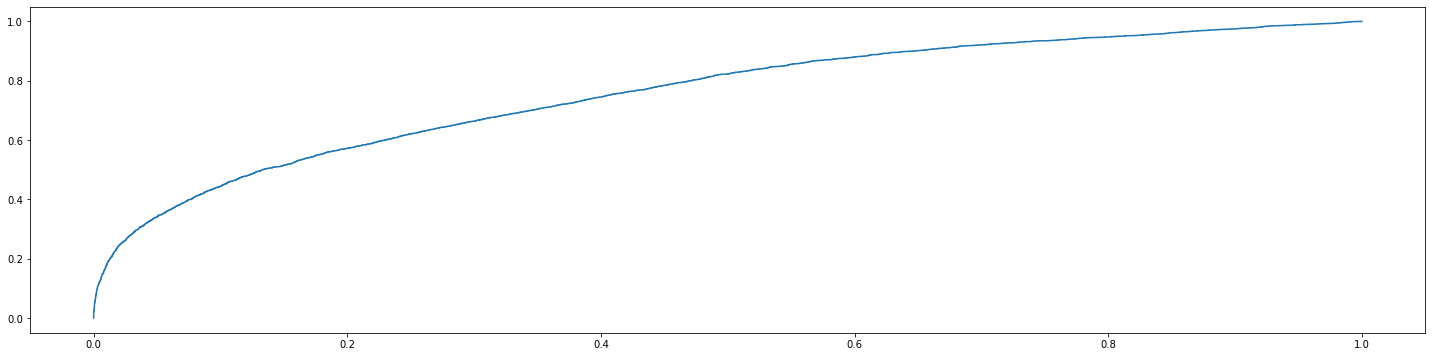

In [54]:
# we need to calculate class probabilities!
y_pred_proba = logisticr.predict_proba(X_test)[:,1]
# predicts prob for class b for every row in dataset, which is positive for us in our case
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='B') 
plt.plot(fpr,tpr)
plt.show()

In [51]:
help(roc_auc_score)

Help on function roc_auc_score in module sklearn.metrics._ranking:

roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)
    Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    from prediction scores.
    
    Note: this implementation can be used with binary, multiclass and
    multilabel classification, but some restrictions apply (see Parameters).
    
    Read more in the :ref:`User Guide <roc_metrics>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_classes)
        True labels or binary label indicators. The binary and multiclass cases
        expect labels with shape (n_samples,) while the multilabel case expects
        binary label indicators with shape (n_samples, n_classes).
    
    y_score : array-like of shape (n_samples,) or (n_samples, n_classes)
        Target scores. In the binary and multilabel cases, these can be either
      

In [52]:
roc_auc_score(y_test, y_pred_proba)
# always between 0.5 and 1, as its Area under curve
# other measurement for wellness of my classification

0.7585101629448793

### Repeating all the steps for a Decision Tree for comparison:

In [55]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)

In [56]:
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)
#accuracy

0.9948900692530088

In [57]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)
# most data on main diagonal, so we mainly have true positives and true negatives

[[25750    89]
 [   63  3844]]


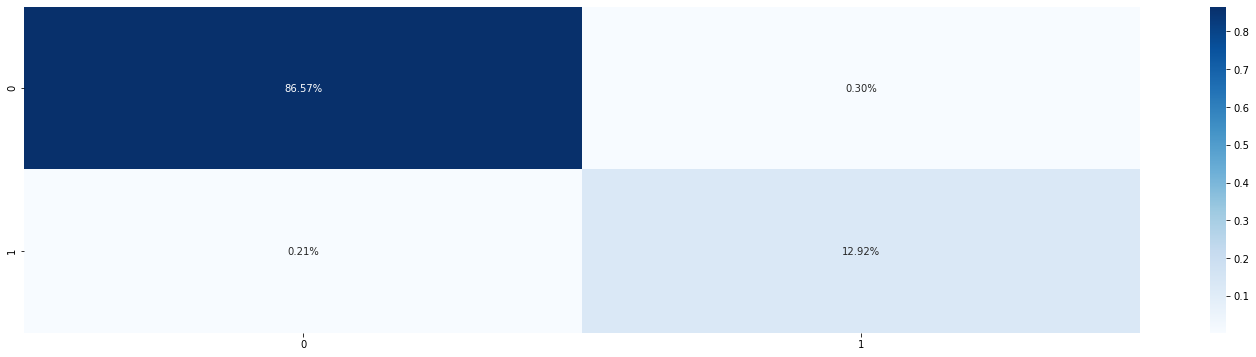

In [58]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [59]:
print(precision_score(y_test, predictions, pos_label='B'))
print(recall_score(y_test, predictions, pos_label='B'))
print(f1_score(y_test, predictions, pos_label='B'))

0.9773709636409865
0.9838750959815715
0.9806122448979592


In [60]:
balanced_accuracy_score(y_test, predictions)

0.9902153451191575

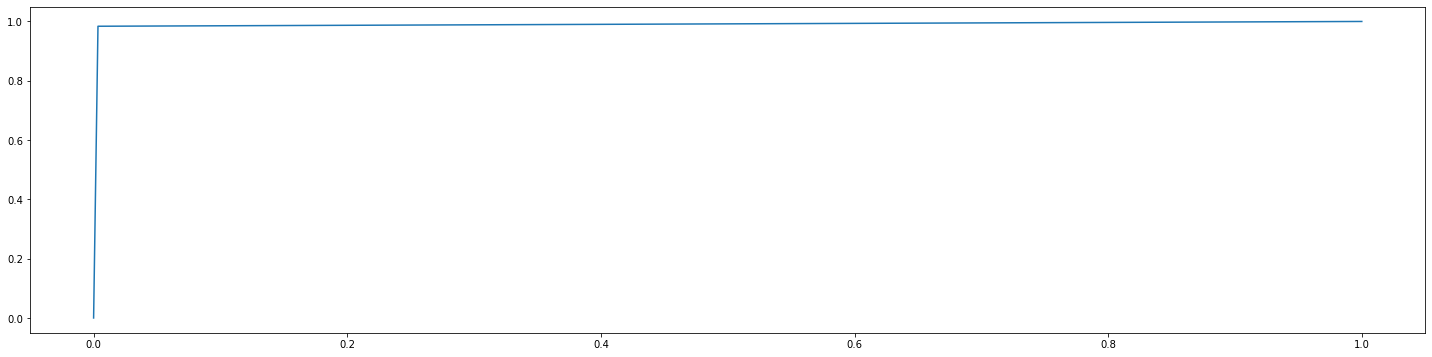

In [63]:
y_pred_proba = decisiontree.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='B') 
# we need to assign which one is the "positive" (1) category
plt.plot(fpr,tpr)
plt.show()

In [62]:
roc_auc_score(y_test, y_pred_proba)

0.9902153451191575